In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants
from pynufft import NUFFT
import scipy.interpolate
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"
from scipy.ndimage import zoom

mm = 1E-3
C = scipy.constants.c

def set_font(fontsize=18, font="Times New Roman"):
    rc = {"font.size" : fontsize,
    "font.family" : font,
    "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
set_font(fontsize=15)

def resample(im, scale, xs, ys, zs):
    im = zoom(im, (scale, scale, scale))
    xs = np.linspace(np.amin(xs), np.amax(xs), im.shape[1])
    ys = np.linspace(np.amin(ys), np.amax(ys), im.shape[0])
    zs = np.linspace(np.amin(zs), np.amax(zs), im.shape[2])
    Xs, Ys, Zs = np.meshgrid(xs, ys, zs, indexing='xy')
    return im, Xs, Ys, Zs

def padortruncate(array, dx, dy, val_bg=0):
    '''
    Pads (with value val_bg) or truncates array depending on whether array dimensions are great than or less than (dx, dy)

    '''
    dx = int(dx)
    dy = int(dy)
    nx = max((dx-array.shape[1])//2, 0)
    ny = max((dy-array.shape[0])//2, 0)
    px = max((array.shape[1]-dx)//2, 0)
    py = max((array.shape[0]-dy)//2, 0)
    newarray = val_bg * np.ones((dy, dx), dtype=array.dtype)
    cx = min(array.shape[1], dx)
    cy = min(array.shape[0], dy)
    newarray[ny:ny+cy, nx:nx+cx] = array[py:py+cy, px:px+cx]

    return newarray

def padortruncate3d(array, dx, dy, dz, val_bg=0):
    '''
    Pads (with value val_bg) or truncates array depending on whether array dimensions are great than or less than (dx, dy)

    '''
    dx = int(dx)
    dy = int(dy)
    dz = int(dz)
    nx = max((dx-array.shape[0])//2, 0)
    ny = max((dy-array.shape[1])//2, 0)
    nz = max((dz-array.shape[2])//2, 0)
    px = max((array.shape[0]-dx)//2, 0)
    py = max((array.shape[1]-dy)//2, 0)
    pz = max((array.shape[2]-dz)//2, 0)
    newarray = val_bg * np.ones((dx, dy, dz), dtype=array.dtype)
    cx = min(array.shape[0], dx)
    cy = min(array.shape[1], dy)
    cz = min(array.shape[2], dz)
    newarray[nx:nx+cx, ny:ny+cy, nz:nz+cz] = array[px:px+cx, py:py+cy, pz:pz+cz]

    return newarray

def fft_resample(img, height, width):
    '''
    Resamples image img by padding or truncating in the Fourier domain.

    '''
    img = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(img)))
    scal = img.size
    img = padortruncate(img, height, width)
    scal = img.size / scal
    img = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(img)))*scal

    return img

def G(k, R):
    return np.exp(-1j*k*R)/R

### Define antenna coordinates

In [2]:
d_antennas = .035        # MEASURE THIS, gives distance between tx/rx antennas
z_offset = 0.76
MAR = 2*z_offset        # maximum unambiguous range
delta_f = C/(2*MAR)
fc = 22E9
bw = 2E9
Nf = int(np.ceil(bw/delta_f))

f = np.linspace(fc-bw/2, fc+bw/2, Nf)
lam = C/f
k = 2*np.pi/lam

L_horn = .05
a_horn = 10.668*mm      # WR42
b_horn = 4.318*mm
beta_g = np.sqrt(k**2 - (np.pi/a_horn)**2)
phase_error = np.exp(1j*2*beta_g*L_horn)    # 2 for transmit and receive path

Lxa = .5
Lya = .5
delta_xa = np.amin(lam)/2
delta_ya = np.amin(lam)/2
xa = np.arange(-Lxa/2, Lxa/2+delta_xa, delta_xa)
ya = np.arange(-Lya/2, Lya/2+delta_ya, delta_ya)
Xa, Ya = np.meshgrid(xa, ya, indexing='xy')
Za = np.zeros_like(Xa)

Nx = xa.size
Ny = ya.size
Na = Xa.size
M = Na*Nf

### Simulate signal

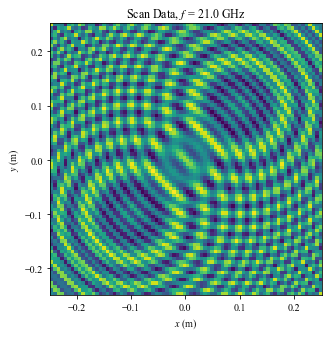

In [3]:
x_target = -0.1
y_target = -0.1
z_target = z_offset
target = np.array([x_target, y_target, z_target])[None,:]
target = np.concatenate((target, np.array([x_target+.2, y_target+.2, z_target])[None,:]), axis=0)

measurements = np.zeros((ya.size, xa.size, Nf), dtype=np.complex64)
for t in range(target.shape[0]):
    Rt = np.sqrt((Xa + d_antennas/2 - target[t,0])**2 + (Ya - target[t,1])**2 + (Za - target[t,2])**2)
    Rr = np.sqrt((Xa - d_antennas/2 - target[t,0])**2 + (Ya - target[t,1])**2 + (Za - target[t,2])**2)
    for kk in range(f.size):
        measurements[:,:,kk] += G(k[kk], Rt) * G(k[kk], Rr)

measurements = measurements * phase_error[None,None,:]

set_font(fontsize=15)
fig = plt.figure(figsize=(5,5))
plt.imshow(np.real(measurements[:,:,0]),
           extent=(np.amin(xa), np.amax(xa), np.amin(ya), np.amax(ya)),
           origin='lower')
plt.title('Scan Data, $f$ = {} GHz'.format(f[0]*1E-9))
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.show()

### Define reconstruction region

In [4]:
Lxs = .6
Lys = .6
Lzs = .6

cr_res_x = np.amin(lam)*z_offset/(2*Lxa)
cr_res_y = np.amin(lam)*z_offset/(2*Lya)
r_res_z = C/bw

delta_xs = cr_res_x/5
delta_ys = cr_res_y/5
delta_zs = r_res_z/5

xs_offset = 0
ys_offset = 0
zs_offset = z_offset


### Reconstruct

In [5]:
### correct for probe phase
measurements = measurements / phase_error[None,None,:]

pad_x = int(Lxs // delta_xa)
pad_y = int(Lys // delta_ya)

measurements_pad = padortruncate3d(measurements, pad_x, pad_y, measurements.shape[2])
Nx_pad = measurements_pad.shape[1]
Ny_pad = measurements_pad.shape[0]
measurements_ft = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(
                        measurements_pad,
                        axes=(0,1)), axes=(0,1)), axes=(0,1))
delta_kx = 2*np.pi/(delta_xa * Nx_pad)
delta_ky = 2*np.pi/(delta_ya * Ny_pad)
kx = np.arange(-np.floor(Nx_pad/2), np.ceil(Nx_pad/2)) * delta_kx
ky = np.arange(-np.floor(Ny_pad/2), np.ceil(Ny_pad/2)) * delta_ky
Kx, Ky, K = np.meshgrid(kx.astype(np.complex64), ky.astype(np.complex64), k.astype(np.complex64), indexing='xy')
Kz = np.sqrt(4*K**2 - Kx**2 - Ky**2)
measurements_ft[np.imag(Kz)!=0] = 0
Kz[np.imag(Kz)!=0] = 0
Kz = np.real(Kz)

filt = np.nan_to_num(K / Kz**2)
measurements_ft = measurements_ft * np.exp(1j * Kz * zs_offset) / filt

delta_kz = 2*np.pi/Lzs
kz_linear = np.arange(np.amin(Kz), np.amax(Kz), delta_kz)

def interp1d(x_new, x, y, kind='linear'):
    f_real = scipy.interpolate.interp1d(x, np.real(y), kind=kind, bounds_error=False, fill_value=0)
    f_imag = scipy.interpolate.interp1d(x, np.imag(y), kind=kind, bounds_error=False, fill_value=0)
    f_interp = f_real(x_new) + 1j*f_imag(x_new)
    return f_interp

measurements_stolt_real = np.zeros((measurements_ft.shape[0], measurements_ft.shape[1], kz_linear.size), dtype=np.float32)
measurements_stolt_imag = np.zeros((measurements_ft.shape[0], measurements_ft.shape[1], kz_linear.size), dtype=np.float32)
measurements_stolt = np.zeros((measurements_ft.shape[0], measurements_ft.shape[1], kz_linear.size), dtype=np.complex128)
for i in range(measurements_ft.shape[0]):
    for j in range(measurements_ft.shape[1]):
        if (Kz[i,j,Kz[i,j,:]!=0]).size >= 2:
            # measurements_stolt_real[i,j,:] = np.interp(kz_linear, Kz[i,j,Kz[i,j,:]!=0], np.real(measurements_ft[i,j,Kz[i,j]!=0]), left=0, right=0)
            # measurements_stolt_imag[i,j,:] = np.interp(kz_linear, Kz[i,j,Kz[i,j,:]!=0], np.imag(measurements_ft[i,j,Kz[i,j]!=0]), left=0, right=0)
            measurements_stolt[i,j,:] = interp1d(kz_linear, Kz[i,j,Kz[i,j,:]!=0], measurements_ft[i,j,Kz[i,j]!=0], kind='linear')
# measurements_stolt = measurements_stolt_real + 1j*measurements_stolt_imag
measurements_stolt = np.nan_to_num(measurements_stolt)

%matplotlib qt
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax1.imshow(np.abs(measurements_stolt[measurements_stolt.shape[0]//2, :, :]))
ax2 = fig.add_subplot(132)
ax2.imshow(np.abs(measurements_stolt[:,measurements_stolt.shape[1]//2,:]))
ax3 = fig.add_subplot(133)
ax3.imshow(np.abs(measurements_stolt[:,:,measurements_stolt.shape[2]//2]))

Lkx = 2*np.pi/delta_xs
Lky = 2*np.pi/delta_ys
Lkz = 2*np.pi/delta_zs
# measurements_stolt = padortruncate3d(measurements_stolt, Lkx//delta_kx, Lky//delta_ky, Lkz//delta_kz)

im = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(measurements_stolt)))

fig = plt.figure()
ax1 = fig.add_subplot(131)
ax1.imshow(np.abs(measurements_stolt[measurements_stolt.shape[0]//2, :, :]))
ax2 = fig.add_subplot(132)
ax2.imshow(np.abs(measurements_stolt[:,measurements_stolt.shape[1]//2,:]))
ax3 = fig.add_subplot(133)
ax3.imshow(np.abs(measurements_stolt[:,:,measurements_stolt.shape[2]//2]))

xs = np.linspace(-Lxs/2, Lxs/2, im.shape[1])
ys = np.linspace(-Lys/2, Lys/2, im.shape[0])
zs = np.linspace(-Lzs/2, Lzs/2, im.shape[2])
Xs, Ys, Zs = np.meshgrid(xs, ys, zs, indexing='xy')

### Plot

In [6]:
scale = 1
im, Xs, Ys, Zs = resample(im, scale, xs, ys, zs)

# im_2d = np.abs(np.mean(im, 2))**2
im_2d = np.abs(im[:,:,im.shape[2]//2])**2
im_2d = 10*np.log10(im_2d/np.amax(im_2d))

# %matplotlib qt
set_font(fontsize=15)
plt.figure()
plt.imshow(im_2d,
           extent=(np.amin(xs), np.amax(xs), np.amin(ys), np.amax(ys)),
           origin='lower')
plt.clim(-40, 0)
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.title('Reconstruction')
plt.colorbar(label='dB')
plt.show()

In [7]:
scale = 'linear'
cmap = 'Turbo'

im_plot = np.abs(im)**2
im_plot = im_plot/np.amax(im_plot)
if scale == 'dB':
    im_plot = 10*np.log10(im_plot)
if scale == 'linear':
    colormin = 0
    colormax = 1
else:
    colormin = -10
    colormax = 0

surface_count = 20
opacity = 0.1

fig = go.Figure(data=go.Volume(
                x=Zs.flatten(),
                y=Xs.flatten(),
                z=Ys.flatten(),
                value=im_plot.flatten(),
                name='Reconstruction',
                isomin=colormin,
                isomax=colormax,
                opacity=opacity, # needs to be small to see through all surfaces
                surface_count=surface_count, # needs to be a large number for good volume rendering
                colorscale=cmap,
                caps= dict(x_show=False, y_show=False, z_show=False),
                opacityscale='uniform'
            ))
fig.show()